**Repository**: https://github.com/EstebanMqz/SP500-Risk-Optimized-Portfolios-PostCovid-ML

### <font color= 'orange'> **S & P 500 Risk Optimized Portfolios PostCovid ML** <font> 

In [2]:
#Import dependencies
import functions as fn
import data as dt
import visualizations as vs

#Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("dark_background")
%matplotlib inline

import scipy
import scipy.stats as st
from scipy import optimize
from scipy.optimize import minimize

import sklearn
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV 
from sklearn import metrics

from yahoofinancials import YahooFinancials 
from tabulate import tabulate
import IPython.display as d

import datetime 
import time

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=UserWarning)

##### <span style='color:red'> Project Creators:</span> Create requirements.txt file.<br>

In [ ]:
docstring = """
# -- --------------------------------------------------------------------------------------------------  -- # 
# -- project: S&P500-Risk-Optimized-Portfolios-PostCovid-ML                                              -- # 
# -- script: requirements.txt: txt file to download Python modules for execution                         -- # 
# -- author: EstebanMqz                                                                                  -- # 
# -- license: CC BY 3.0                                                                                  -- # 
# -- repository: SP500-Risk-Optimized-Portfolios-PostCovid-ML/blob/main/requirements.txt                 -- #                                  
# -- --------------------------------------------------------------------------------------------------  -- # 
\n
"""

fn.get_requirements(docstring)

##### <span style='color:green'> Project Users:</span> Install libraries in requirements.txt file.<br>

In [ ]:
dt.library_install("requirements.txt")

*Fetching a lot of data from Yahoo Finance by batches is required to avoid host disruptions. Other sources could be used too.*<br>

In [3]:
tickers=fn.SP500_tickers(50)
tickers[0][:5], tickers[-1][-5:]

(['MMM', 'AOS', 'ABT', 'ABBV', 'ACN'], ['ZBH', 'ZION', 'ZTS'])

##### <span style='color:lightgray'> Fetching S&P 500 data </span>
takes 5-10 min. for 10y.<br><br>
<span style='color:yellow'> *(skip to read-only .csv)*.



In [ ]:
data = pd.concat([dt.get_historical_price_data(tickers[i][j], 6) for i in range(0, len(tickers)) for j in range(0, len(tickers[i]))], axis=1)

In [ ]:
data.head()

In [ ]:
data.tail()
data.to_csv("sp500.csv")

<span style='color:lightgreen'> Read-only .csv </span> <br> 

Now that we have downloaded our $data_{17_{05}-23_{05}}$ we can start analyzing it with by calculating $R_{yr}$, $\sigma_{yr}$ and the following *risk-return* $Ratios$ with their respective $\beta$. <br>

$Beta = \frac{Cov(R_{p},R_{mkt})}{Var(R_{mkt})}$ <br><br>

$R_{Sharpe} = \frac{Returns - {rf}}{\sigma}$ ,&nbsp;&nbsp; $R_{Sortino} = \frac{Returns - {rf}}{\sigma_{downside}}$ ,&nbsp;&nbsp; $R_{Treynor} = \frac{Returns - {rf}}{\beta}$ ,&nbsp;&nbsp; $R_{Jensen} = {rf} + \beta(R_{mkt} - {rf})$ <br><br>

,Annualized Return,Volatility,Sharpe Ratio,Sortino Ratio
ENPH,1.518291,0.789591,1.901479,3.293286
TDG,0.451852,0.255364,1.703261,2.788401
DXCM,0.786397,0.501397,1.534707,2.616126
CMG,0.602974,0.364806,1.606536,2.569614
AMD,0.920863,0.585987,1.542632,2.404627
CSGP,0.405487,0.268307,1.448293,2.364980
PAYC,0.688312,0.395736,1.696613,2.363065
FICO,0.500005,0.287623,1.679648,2.311393
KEYS,0.504359,0.319989,1.523362,2.273103
ZTS,0.344071,0.221555,1.476701,2.238899


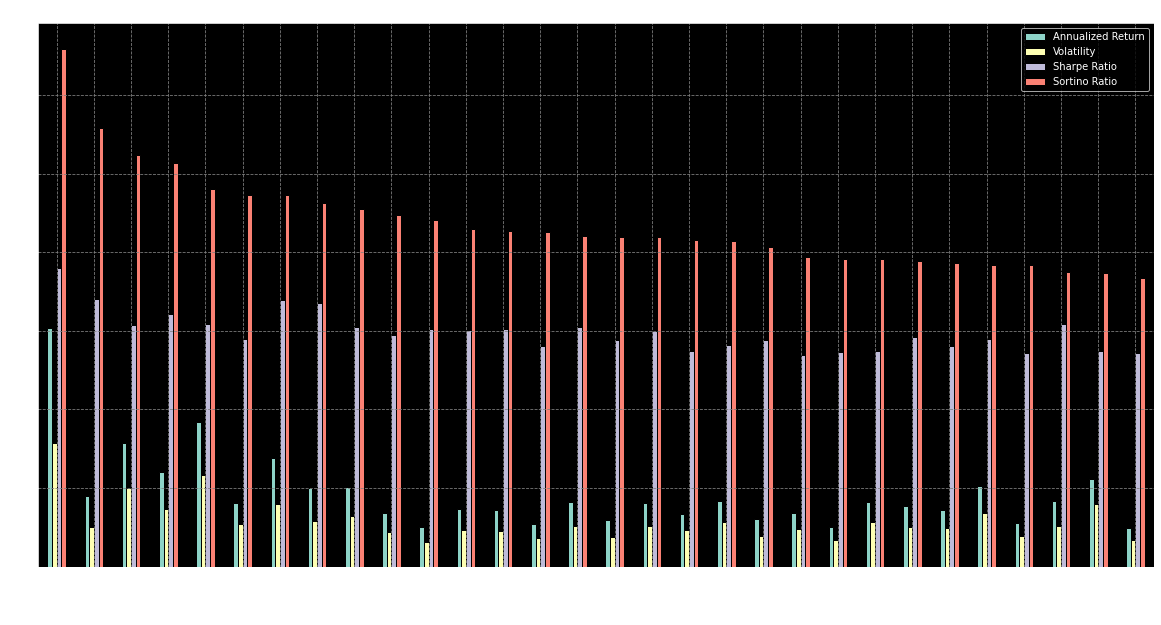

In [4]:
SP_Assets = pd.read_csv("Data/sp500.csv", index_col=0)
Asset_Selection18_20 = vs.selection_data(SP_Assets.loc["2018-01-02":"2020-01-02"], 0.0169, "S&P500 Asset Selection 2018-2020")[0]

Asset_Selection18_20

For $i = 1,2,3,...n$ samples if $x_i$ ~ $N(\mu, \sigma^2)$ then: <br>

in an equally weighted dataset we *would* have the following params : <br><br>

$$\mu_{{x_{i}}}, \sigma_{i} = \frac{1}{n} \bigg(\sum_{i=1}^{n} \mu_{{x_{i}}}, \sqrt{\sum_{i=1}^{n}\left(\mu_{{x_{i}}}-\bar{\mu}\right)^{2}}\bigg)$$
<br>

In a weighted dataset with unknown distributions, weights are:<br>

$$\sum_{n}^{} w=1$$

For *i.i.d* randomly generated variables $\forall x_i \in X_{i}\sim U(0,1)$<br>
with the property $E(X+Y) = E(X) + E(Y)$, the best estimator for $\mu_{p}$ is easily obtained: <br>


$$\mu_{P} = \frac{1}{n} \sum_{i=1}^{n} w_{i} \sum_{i=1}^{n} \mu_{{x_{i}}} = \sum_{i=1}^n (w_i) \mu_{{x_{i}}}$$ 

To calculate $\sigma_p$ we need the variance of the sum of the random variables: <br>

$$\sigma_{P} = \sqrt{\sum_{i=1}^{n} w_{i}^{2} \sigma_{i}^{2} + \sum_{i=1}^{n} \sum_{j=1, j \neq i}^{n} w_{i} w_{j} \sigma_{i} \sigma_{j} \rho_{i j}}$$

where $\rho_{i j} = \frac{Cov(X_i, X_j)}{\sigma_{i} \sigma_{j}}$ is the correlation coefficient.

So it can be reduced to $\sigma_{P} = \sqrt{w^{T} \times COV_{1,n} \times w}$ and solved as a product of matrices $\times$ vectors: <br><br><br>

$$\sigma_{P} = \sqrt{\left[\begin{array}{cccc}w_{1} & w_{2} & \cdots & w_{n}\end{array}\right] \cdot \left[\begin{array}{cccc}1 & \rho_{1,2} & \cdots & \rho_{1,n} \\ \rho_{2,1} & 1 & \cdots & \rho_{2,n} \\ \vdots & \vdots & \ddots & \vdots \\ p_{n,1} & \cdots & \cdots & 1\end{array}\right] \cdot \left[\begin{array}{cccc}w_{1} \\ w_{2} \\ \vdots \\ w_{n}\end{array}\right]}$$

where $\beta$ = $ \frac{Cov(r_{P},r_{mkt})}{Var(r_{mkt})}$ <br><br>

Therefore, we can verify that the following are the optimized portfolios:
+ $Sharpe_{Arg_{max}} \bigg(E\bigg[\frac{r_P}{\sigma}\bigg]\bigg)$ : <br><br>
+ $Min_{Var{Arg_{max}}}$ :<br><br>
+ $Sortino_{Arg_{max}} \bigg(E\bigg[\frac{r_P}{\sigma_{(r_p)<0}}\bigg]\bigg)$ : <br><br>
+ $Traynor_{Arg_{max}} \bigg(E\bigg[\frac{r_P}{\beta}\bigg]\bigg)$ : <br><br>

on given periods

In [ ]:
    # def Min_Var(weights, cov):
    #     return np.dot(weights.T, np.dot(cov, weights))        BIEN
#-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------   
    # def Max_Traynor(weights, r, rf, cov):
    #     rp = np.dot(weights.T, r)
    #     smkt = SP
    #     beta = np.divide(cov, sp)
    #     return -np.divide(np.subtract(rp, rf), beta)

    # Jensen (mean_ret - np.dot((rf + beta(data, rf)), (mean_ret - rf)))            NO
 #------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------      
    # Wopt_MinVar = optimize.minimize(Min_Var, np.ones(N) / N, (cov,), 'SLSQP', bounds = bnds,
    #                 constraints = cons, options={"tol": 1e-10})
    # Ropt_MinVar = np.dot(Wopt_MinVar.x.T, mean_ret)
    # Sopt_MinVar = np.sqrt(np.dot(Wopt_MinVar.x.T, np.dot(cov, Wopt_MinVar.x)))
    # Bopt_MinVar = (np.cov(Asset_ret.iloc[:, 0], index_ret.iloc[:, 0])[0][1]) / index_variance[0]
    # Popt_MinVar = pd.DataFrame({"$\mu$" : Ropt_MinVar, "$\sigma$" : Sopt_MinVar, "$\beta$" : Bopt_MinVar, 
    #                             "$Sharpe-R_{max}$" : (Ropt_MinVar - rf) / Sopt_MinVar}, index = ["$Min_{Var{Arg_{max}}}$"])   
    # Popt_MinVar.index.name = title                                                                                                                MEDIAS
#------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [309]:
def Optimizer(Assets, index, rf, title):
    Asset_ret = (Assets.pct_change()).iloc[1:, :].dropna(axis = 1)
    mean_ret = Asset_ret.mean() * 252
    # Asset_std = Asset_ret.std() * np.sqrt(252)
    # Asset_variance = Asset_ret.var() * 252
    cov = Asset_ret.cov() * 252

    index_ret = index.pct_change().iloc[1:, :].dropna(axis = 1)
    # index_mean_ret = index_ret.mean() * 252
    # index_std = index_ret.std() * np.sqrt(252)
    # index_variance = index.var() * 252

    N = len(mean_ret)
    w0 = np.ones(N) / N
    bnds = ((0, None), ) * N
    cons = {"type" : "eq", "fun" : lambda weights : weights.sum() - 1}

    def Max_Sharpe(weights, Asset_ret, rf, cov):
        rp = np.dot(weights.T, Asset_ret)
        sp = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))
        RS = (rp - rf) / sp
        return -(np.divide(np.subtract(rp, rf), sp))
    
    opt_EMV = optimize.minimize(Max_Sharpe, w0, (mean_ret, rf, cov), 'SLSQP', bounds = bnds,
                                 constraints = cons, options={"tol": 1e-10})
    
    W_EMV = pd.DataFrame(np.round(opt_EMV.x.reshape(1, N), 4), columns = Asset_ret.columns, index = ["Weights"])
    W_EMV[W_EMV <= 0.0] = np.nan
    W_EMV.dropna(axis = 1, inplace = True)

    RAssets = Asset_ret[Asset_ret.columns[Asset_ret.columns.isin(W_EMV.columns)]]
    # MuAssets = mean_ret[mean_ret.index.isin(W_EMV.columns)]
    R_EMV = pd.DataFrame((RAssets*W_EMV.values).sum(axis = 1), columns = ["$r_{P_{EMV}}$"])
    index_ret.rename(columns={index_ret.columns[0]: "$r_{mkt}$" }, inplace=True)
    R_EMV.insert(1, index_ret.columns[0], index_ret.values)

    Muopt_EMV = np.dot(opt_EMV.x.T, mean_ret) 
    Sopt_EMV = np.sqrt(np.dot(opt_EMV.x.T, np.dot(cov, opt_EMV.x)))
    Beta = np.divide((np.cov(R_EMV.iloc[0], R_EMV.iloc[1])[0][1]), R_EMV.iloc[1].var())

    Popt_EMV = pd.DataFrame({"$\mu$" : Muopt_EMV, "$\sigma$" : Sopt_EMV, "$\Beta$": Beta, "$Sharpe-R_{max}$" : (Muopt_EMV - rf) / Sopt_EMV},
                             index = ["$Sharpe_{Arg_{max}} : EMV$"])
    Popt_EMV.index.name = title

    Ratios = pd.concat([Popt_EMV], axis = 0)
    Argmax = d.Markdown(tabulate(Ratios, headers = "keys", tablefmt = "pipe"))
    R_EMV = d.Markdown(tabulate(R_EMV, headers = "keys", tablefmt = "pipe"))
    
    return Argmax, R_EMV, W_EMV

In [310]:
Argmax, R_EMV, W_EMV = Optimizer(SP_Assets.loc["2018-01-02":"2020-01-02"], dt.get_historical_price_data('^GSPC', 6).loc["2018-01-02":"2020-01-02"], 0.0169, "$S\&P500_{18-20}$")

In [311]:
Argmax

| $S\&P500_{18-20}$          |    $\mu$ |   $\sigma$ |   $\Beta$ |   $Sharpe-R_{max}$ |
|:---------------------------|---------:|-----------:|----------:|-------------------:|
| $Sharpe_{Arg_{max}} : EMV$ | 0.477826 |   0.134836 |  0.306639 |            3.41843 |

In [312]:
W_EMV

,AES,AMD,AMT,AZO,CMG,CPRT,DXCM,ENPH,ETR,FE,...,MKC,MRK,NEM,NEE,SRE,SO,TGT,TDG,GWW,ZBRA
Weights,0.0538,0.0286,0.0207,0.0562,0.0963,0.0269,0.0448,0.0794,0.0206,0.0849,...,0.0188,0.0027,0.0171,0.1339,0.0115,0.0034,0.0365,0.001,0.0015,0.0087


In [313]:
R_EMV

| formatted_date   |   $r_{P_{EMV}}$ |    $r_{mkt}$ |
|:-----------------|----------------:|-------------:|
| 2018-01-03       |     0.00385232  |  0.00639882  |
| 2018-01-04       |    -0.00427591  |  0.00402864  |
| 2018-01-05       |     0.00366998  |  0.00703377  |
| 2018-01-08       |     0.0052859   |  0.00166234  |
| 2018-01-09       |    -0.00545455  |  0.00130293  |
| 2018-01-10       |    -0.00156697  | -0.00111223  |
| 2018-01-11       |     0.0112745   |  0.00703365  |
| 2018-01-12       |    -0.00314202  |  0.0067496   |
| 2018-01-16       |    -0.009236    | -0.00352449  |
| 2018-01-17       |     0.00970765  |  0.00941505  |
| 2018-01-18       |    -0.00339716  | -0.00161639  |
| 2018-01-19       |     0.00633611  |  0.00438524  |
| 2018-01-22       |     0.00266457  |  0.00806673  |
| 2018-01-23       |     0.00538993  |  0.00217437  |
| 2018-01-24       |    -0.00681783  | -0.000559976 |
| 2018-01-25       |     0.00961807  |  0.000602621 |
| 2018-01-26       |     0.00986973  |  0.0118412   |
| 2018-01-29       |     0.0180609   | -0.00673197  |
| 2018-01-30       |    -0.00399529  | -0.0108988   |
| 2018-01-31       |     0.0140166   |  0.000488985 |
| 2018-02-01       |    -0.00927462  | -0.000648088 |
| 2018-02-02       |    -0.0164159   | -0.0212085   |
| 2018-02-05       |    -0.0107936   | -0.0409792   |
| 2018-02-06       |    -0.00229236  |  0.0174409   |
| 2018-02-07       |    -0.0054633   | -0.00500159  |
| 2018-02-08       |    -0.0268974   | -0.0375364   |
| 2018-02-09       |     0.00510444  |  0.0149361   |
| 2018-02-12       |     0.0205866   |  0.0139146   |
| 2018-02-13       |     0.00649049  |  0.00261293  |
| 2018-02-14       |     0.0151077   |  0.0134025   |
| 2018-02-15       |     0.0141481   |  0.0120691   |
| 2018-02-16       |     0.0100107   |  0.000373469 |
| 2018-02-20       |    -0.00886256  | -0.00584139  |
| 2018-02-21       |    -0.00289371  | -0.0054965   |
| 2018-02-22       |    -0.00600298  |  0.000973551 |
| 2018-02-23       |     0.013976    |  0.0160284   |
| 2018-02-26       |     0.00975152  |  0.011757    |
| 2018-02-27       |    -0.00348804  | -0.0127069   |
| 2018-02-28       |     0.0100173   | -0.0110958   |
| 2018-03-01       |    -0.00441664  | -0.0133244   |
| 2018-03-02       |     0.00621319  |  0.0050716   |
| 2018-03-05       |     0.0155324   |  0.011032    |
| 2018-03-06       |     0.00415902  |  0.00263886  |
| 2018-03-07       |     0.00168651  | -0.000483875 |
| 2018-03-08       |     0.000755859 |  0.00446308  |
| 2018-03-09       |     0.00800575  |  0.0173788   |
| 2018-03-12       |     0.00715273  | -0.00127399  |
| 2018-03-13       |     0.000733611 | -0.00636358  |
| 2018-03-14       |     0.00675082  | -0.00572452  |
| 2018-03-15       |     0.00168399  | -0.000781931 |
| 2018-03-16       |     0.0121141   |  0.00170345  |
| 2018-03-19       |    -0.00407909  | -0.0142042   |
| 2018-03-20       |     0.00316118  |  0.00148181  |
| 2018-03-21       |     0.00412418  | -0.00184399  |
| 2018-03-22       |    -0.00281297  | -0.0251629   |
| 2018-03-23       |    -0.00916618  | -0.0209669   |
| 2018-03-26       |     0.0142028   |  0.0271573   |
| 2018-03-27       |    -0.00170948  | -0.0172763   |
| 2018-03-28       |    -0.00679114  | -0.00291666  |
| 2018-03-29       |     0.00781168  |  0.0137697   |
| 2018-04-02       |    -0.0148098   | -0.0223374   |
| 2018-04-03       |     0.000203082 |  0.0126149   |
| 2018-04-04       |     0.00908392  |  0.0115665   |
| 2018-04-05       |     0.00519812  |  0.00686286  |
| 2018-04-06       |    -0.0158574   | -0.0219202   |
| 2018-04-09       |     0.00016974  |  0.00333655  |
| 2018-04-10       |     0.00470878  |  0.016727    |
| 2018-04-11       |    -0.0012046   | -0.00552536  |
| 2018-04-12       |     0.000925645 |  0.00825075  |
| 2018-04-13       |    -0.00370139  | -0.00288663  |
| 2018-04-16       |     0.00959944  |  0.00810904  |
| 2018-04-17       |     0.0159262   |  0.0106615   |
| 2018-04-18       |    -0.000705464 |  0.000831366 |
| 2018-04-19       |     0.00179339  | -0.00572612  |
| 2018-04-20       |    -0.00331325  | -0.00853653  |
| 2018-04-23       |     0.00344374  |  5.62317e-05 |
| 2018-04-24       |    -0.00817996  | -0.0133806   |
| 2018-04-25       |    -0.00105953  |  0.00183706  |
| 2018-04-26       |     0.0343631   |  0.0104342   |
| 2018-04-27       |     0.00140713  |  0.00111362  |
| 2018-04-30       |    -0.00623845  | -0.00818749  |
| 2018-05-01       |    -0.00364837  |  0.00254905  |
| 2018-05-02       |     0.0100826   | -0.00720586  |
| 2018-05-03       |     0.00261537  | -0.00225367  |
| 2018-05-04       |     0.00315138  |  0.0128112   |
| 2018-05-07       |     0.00732838  |  0.00345795  |
| 2018-05-08       |    -0.00665963  | -0.000265641 |
| 2018-05-09       |     0.00773482  |  0.00968222  |
| 2018-05-10       |     0.0145456   |  0.00937064  |
| 2018-05-11       |     0.00161009  |  0.0017076   |
| 2018-05-14       |     0.0014022   |  0.00088349  |
| 2018-05-15       |    -0.00107385  | -0.00684214  |
| 2018-05-16       |     0.00872698  |  0.00406056  |
| 2018-05-17       |    -0.00466577  | -0.000855872 |
| 2018-05-18       |    -0.0049376   | -0.00263219  |
| 2018-05-21       |     0.0113482   |  0.00738675  |
| 2018-05-22       |    -0.00723966  | -0.00313576  |
| 2018-05-23       |     0.00552565  |  0.00324841  |
| 2018-05-24       |     0.00606778  | -0.00202321  |
| 2018-05-25       |    -0.00104025  | -0.00235722  |
| 2018-05-29       |     0.00353549  | -0.0115642   |
| 2018-05-30       |     0.0173173   |  0.0126958   |
| 2018-05-31       |    -0.0100339   | -0.00687956  |
| 2018-06-01       |     0.00609185  |  0.0108492   |
| 2018-06-04       |     0.00526888  |  0.0044796   |
| 2018-06-05       |    -0.00163587  |  0.000702593 |
| 2018-06-06       |    -0.00910692  |  0.00856739  |
| 2018-06-07       |    -0.00269289  | -0.000714188 |
| 2018-06-08       |     0.00304052  |  0.0031259   |
| 2018-06-11       |     0.00117061  |  0.00106871  |
| 2018-06-12       |     0.00398267  |  0.00174339  |
| 2018-06-13       |     0.0235417   | -0.00402613  |
| 2018-06-14       |     0.0110577   |  0.00247155  |
| 2018-06-15       |    -0.00610789  | -0.0010171   |
| 2018-06-18       |     0.00977287  | -0.00212613  |
| 2018-06-19       |     0.00419023  | -0.0040234   |
| 2018-06-20       |    -0.00227507  |  0.00171215  |
| 2018-06-21       |    -0.00245253  | -0.00634551  |
| 2018-06-22       |     0.00804829  |  0.00186193  |
| 2018-06-25       |    -0.00124234  | -0.0137247   |
| 2018-06-26       |     0.00461277  |  0.00220458  |
| 2018-06-27       |    -0.00936317  | -0.00860436  |
| 2018-06-28       |     0.000848571 |  0.00617869  |
| 2018-06-29       |    -0.00165973  |  0.000758403 |
| 2018-07-02       |     0.0127831   |  0.00306796  |
| 2018-07-03       |    -0.000620961 | -0.00494735  |
| 2018-07-05       |     0.0041552   |  0.0086208   |
| 2018-07-06       |     0.00680695  |  0.00848128  |
| 2018-07-09       |     0.000863182 |  0.00882299  |
| 2018-07-10       |     0.0147567   |  0.00347327  |
| 2018-07-11       |     0.00655547  | -0.0070942   |
| 2018-07-12       |     0.00771823  |  0.00874904  |
| 2018-07-13       |    -0.00345237  |  0.00107924  |
| 2018-07-16       |    -0.00276023  | -0.00102814  |
| 2018-07-17       |     0.00250085  |  0.0039737   |
| 2018-07-18       |    -0.00208079  |  0.00216051  |
| 2018-07-19       |     0.00675655  | -0.00395299  |
| 2018-07-20       |    -0.00605935  | -0.000948448 |
| 2018-07-23       |    -0.00244157  |  0.00183805  |
| 2018-07-24       |    -0.00524372  |  0.00478091  |
| 2018-07-25       |     0.000712139 |  0.00910161  |
| 2018-07-26       |     0.00203532  | -0.0030323   |
| 2018-07-27       |    -0.0110265   | -0.00656221  |
| 2018-07-30       |    -0.00540615  | -0.00575417  |
| 2018-07-31       |     0.00277429  |  0.00488473  |
| 2018-08-01       |     0.00188754  | -0.00104035  |
| 2018-08-02       |     0.0237063   |  0.00492644  |
| 2018-08-03       |    -6.37482e-05 |  0.00464418  |
| 2018-08-06       |     0.0100583   |  0.00353823  |
| 2018-08-07       |     0.00396012  |  0.00282418  |
| 2018-08-08       |    -6.41504e-05 | -0.00026238  |
| 2018-08-09       |     0.000931255 | -0.00144167  |
| 2018-08-10       |    -0.00200651  | -0.00711389  |
| 2018-08-13       |    -0.00603038  | -0.00400599  |
| 2018-08-14       |     0.0025914   |  0.00638925  |
| 2018-08-15       |    -0.00126778  | -0.00760216  |
| 2018-08-16       |     0.00545158  |  0.00791941  |
| 2018-08-17       |     0.00290986  |  0.00332312  |
| 2018-08-20       |     0.00337966  |  0.00242802  |
| 2018-08-21       |    -0.00186429  |  0.00206854  |
| 2018-08-22       |     0.00398027  | -0.000398152 |
| 2018-08-23       |     0.00284261  | -0.00169126  |
| 2018-08-24       |     0.00350012  |  0.00619884  |
| 2018-08-27       |    -0.00560208  |  0.00767041  |
| 2018-08-28       |     0.00289935  |  0.000269278 |
| 2018-08-29       |     0.00548972  |  0.00570143  |
| 2018-08-30       |    -0.0094731   | -0.00443033  |
| 2018-08-31       |    -0.000405993 |  0.000134478 |
| 2018-09-04       |     0.00555056  | -0.00165432  |
| 2018-09-05       |    -0.00227474  | -0.00280313  |
| 2018-09-06       |    -0.00162459  | -0.00365231  |
| 2018-09-07       |    -0.00314122  | -0.00221334  |
| 2018-09-10       |     0.00771815  |  0.00189783  |
| 2018-09-11       |     0.00160938  |  0.00373984  |
| 2018-09-12       |     0.00656583  |  0.000356672 |
| 2018-09-13       |    -0.00327182  |  0.00528225  |
| 2018-09-14       |    -0.000915494 |  0.000275482 |
| 2018-09-17       |    -0.0111097   | -0.00556972  |
| 2018-09-18       |     0.0104864   |  0.00536901  |
| 2018-09-19       |    -0.0134597   |  0.00125327  |
| 2018-09-20       |     0.00519916  |  0.00784059  |
| 2018-09-21       |    -0.00156104  | -0.000368533 |
| 2018-09-24       |    -0.00675331  | -0.00351569  |
| 2018-09-25       |     0.00567283  | -0.0013051   |
| 2018-09-26       |    -0.00754094  | -0.00328928  |
| 2018-09-27       |     0.00769311  |  0.00276329  |
| 2018-09-28       |     0.00134649  | -6.87012e-06 |
| 2018-10-01       |    -0.00494013  |  0.00364111  |
| 2018-10-02       |    -8.4698e-05  | -0.00039669  |
| 2018-10-03       |    -0.00369177  |  0.00071152  |
| 2018-10-04       |    -0.00107356  | -0.00816948  |
| 2018-10-05       |     0.0033467   | -0.00552798  |
| 2018-10-08       |     0.00289084  | -0.000395117 |
| 2018-10-09       |     0.00228566  | -0.0014179   |
| 2018-10-10       |    -0.0148944   | -0.0328642   |
| 2018-10-11       |    -0.00947967  | -0.020573    |
| 2018-10-12       |     0.011475    |  0.0142062   |
| 2018-10-15       |     0.00931669  | -0.00590498  |
| 2018-10-16       |     0.0164183   |  0.0214956   |
| 2018-10-17       |    -0.00661711  | -0.000252662 |
| 2018-10-18       |    -0.00269038  | -0.0143919   |
| 2018-10-19       |    -0.0022135   | -0.00036117  |
| 2018-10-22       |     0.00265838  | -0.00429953  |
| 2018-10-23       |    -0.00871418  | -0.00551183  |
| 2018-10-24       |    -0.00895737  | -0.0308644   |
| 2018-10-25       |     6.77282e-05 |  0.018625    |
| 2018-10-26       |    -0.0130268   | -0.0173273   |
| 2018-10-29       |     0.0045958   | -0.0065596   |
| 2018-10-30       |     0.0169072   |  0.0156668   |
| 2018-10-31       |     0.0132218   |  0.0108513   |
| 2018-11-01       |     0.0180607   |  0.0105578   |
| 2018-11-02       |     0.00240057  | -0.00631669  |
| 2018-11-05       |     0.00736433  |  0.00560032  |
| 2018-11-06       |     0.00983402  |  0.0062593   |
| 2018-11-07       |     0.0199338   |  0.0212089   |
| 2018-11-08       |     0.00792565  | -0.00250892  |
| 2018-11-09       |     0.000400571 | -0.00919901  |
| 2018-11-12       |    -0.00698056  | -0.0197015   |
| 2018-11-13       |    -0.000813911 | -0.00148192  |
| 2018-11-14       |    -0.00376678  | -0.00756741  |
| 2018-11-15       |     0.00304814  |  0.0105938   |
| 2018-11-16       |     0.00332317  |  0.00222331  |
| 2018-11-19       |    -0.0169318   | -0.0166431   |
| 2018-11-20       |    -0.0256878   | -0.0181512   |
| 2018-11-21       |     0.0060163   |  0.00304329  |
| 2018-11-23       |     0.00377143  | -0.00655484  |
| 2018-11-26       |     0.00719446  |  0.0155324   |
| 2018-11-27       |     0.0026035   |  0.00326169  |
| 2018-11-28       |     0.0138049   |  0.022974    |
| 2018-11-29       |    -0.00267799  | -0.00218311  |
| 2018-11-30       |     0.00307453  |  0.00817075  |
| 2018-12-03       |     0.0147412   |  0.0109414   |
| 2018-12-04       |    -0.0100815   | -0.0323649   |
| 2018-12-06       |     0.00225235  | -0.00152223  |
| 2018-12-07       |    -0.00888878  | -0.0233201   |
| 2018-12-10       |     0.00603625  |  0.00176215  |
| 2018-12-11       |     0.00155393  | -0.000356346 |
| 2018-12-12       |     0.00436314  |  0.0054195   |
| 2018-12-13       |     5.76034e-06 | -0.00019993  |
| 2018-12-14       |    -0.0109142   | -0.0190867   |
| 2018-12-17       |    -0.0324357   | -0.0207735   |
| 2018-12-18       |    -0.00435338  |  8.64006e-05 |
| 2018-12-19       |    -0.0136893   | -0.0153957   |
| 2018-12-20       |    -0.0130715   | -0.0157721   |
| 2018-12-21       |    -0.0156988   | -0.0205882   |
| 2018-12-24       |    -0.0228052   | -0.0271123   |
| 2018-12-26       |     0.0386919   |  0.0495937   |
| 2018-12-27       |     0.00505365  |  0.00856268  |
| 2018-12-28       |     0.00223109  | -0.00124158  |
| 2018-12-31       |     0.00793404  |  0.00849248  |
| 2019-01-02       |    -0.00480327  |  0.0012685   |
| 2019-01-03       |    -0.0115091   | -0.0247567   |
| 2019-01-04       |     0.0286398   |  0.0343357   |
| 2019-01-07       |     0.0196722   |  0.00701043  |
| 2019-01-08       |     0.0104121   |  0.00969529  |
| 2019-01-09       |     0.00831842  |  0.00409805  |
| 2019-01-10       |     0.00737494  |  0.00451842  |
| 2019-01-11       |     0.00404199  | -0.000146298 |
| 2019-01-14       |    -0.0118646   | -0.00525753  |
| 2019-01-15       |     0.0165071   |  0.0107217   |
| 2019-01-16       |     0.00801707  |  0.00222199  |
| 2019-01-17       |     0.00784085  |  0.0075914   |
| 2019-01-18       |     0.00193771  |  0.0131831   |
| 2019-01-22       |    -0.00112383  | -0.0141573   |
| 2019-01-23       |     0.0033752   |  0.00220291  |
| 2019-01-24       |     0.00220745  |  0.00137573  |
| 2019-01-25       |     0.000208709 |  0.00848869  |
| 2019-01-28       |    -0.00582602  | -0.00784683  |
| 2019-01-29       |     0.0022372   | -0.00145625  |
| 2019-01-30       |     0.0124852   |  0.0155493   |
| 2019-01-31       |     0.0133195   |  0.0085974   |
| 2019-02-01       |    -0.00430909  |  0.00089861  |
| 2019-02-04       |     0.00324452  |  0.00677624  |
| 2019-02-05       |     0.0060365   |  0.00470842  |
| 2019-02-06       |    -0.00171403  | -0.00222444  |
| 2019-02-07       |     0.016347    | -0.00935714  |
| 2019-02-08       |     0.00501413  |  0.000676201 |
| 2019-02-11       |     0.0109077   |  0.000709103 |
| 2019-02-12       |     0.000436266 |  0.0128902   |
| 2019-02-13       |     0.00195067  |  0.00302399  |
| 2019-02-14       |     0.000296344 | -0.00265164  |
| 2019-02-15       |     0.00649099  |  0.0108788   |
| 2019-02-19       |     0.00146191  |  0.00149874  |
| 2019-02-20       |     0.00103921  |  0.00177711  |
| 2019-02-21       |     0.00566721  | -0.00352644  |
| 2019-02-22       |     0.00606824  |  0.0064111   |
| 2019-02-25       |    -0.000923088 |  0.00123186  |
| 2019-02-26       |    -4.05638e-05 | -0.000790457 |
| 2019-02-27       |     0.00747699  | -0.000544049 |
| 2019-02-28       |    -0.00161389  | -0.00282551  |
| 2019-03-01       |     0.00842769  |  0.00689532  |
| 2019-03-04       |    -0.00459902  | -0.00388056  |
| 2019-03-05       |     0.00216879  | -0.00113153  |
| 2019-03-06       |    -0.00504262  | -0.0065241   |
| 2019-03-07       |    -0.0022497   | -0.00812572  |
| 2019-03-08       |     0.00262038  | -0.00213169  |
| 2019-03-11       |     0.0132378   |  0.014666    |
| 2019-03-12       |     0.00866077  |  0.00295332  |
| 2019-03-13       |     0.00706659  |  0.00694958  |
| 2019-03-14       |    -0.00102264  | -0.000868022 |
| 2019-03-15       |     0.00231388  |  0.0049849   |
| 2019-03-18       |     0.00918396  |  0.00370595  |
| 2019-03-19       |    -0.00463512  | -0.000130562 |
| 2019-03-20       |     0.00238781  | -0.00294435  |
| 2019-03-21       |     0.0146511   |  0.0108525   |
| 2019-03-22       |    -0.0107643   | -0.0189745   |
| 2019-03-25       |     0.000211834 | -0.000839021 |
| 2019-03-26       |     0.00404111  |  0.00718273  |
| 2019-03-27       |    -0.0034499   | -0.00464432  |
| 2019-03-28       |     0.00386097  |  0.00358948  |
| 2019-03-29       |     0.00774414  |  0.00673428  |
| 2019-04-01       |    -0.00355729  |  0.0115686   |
| 2019-04-02       |     0.00168227  |  1.74557e-05 |
| 2019-04-03       |     0.00603012  |  0.00214838  |
| 2019-04-04       |    -0.00757756  |  0.00208464  |
| 2019-04-05       |     0.0120549   |  0.00463643  |
| 2019-04-08       |     0.00440812  |  0.00104746  |
| 2019-04-09       |    -0.00272435  | -0.00606749  |
| 2019-04-10       |     0.00622578  |  0.00347787  |
| 2019-04-11       |    -0.00648225  |  3.81231e-05 |
| 2019-04-12       |     0.00139883  |  0.00660932  |
| 2019-04-15       |    -0.00160736  | -0.000629369 |
| 2019-04-16       |    -0.00696007  |  0.000509358 |
| 2019-04-17       |    -0.00850068  | -0.00227381  |
| 2019-04-18       |     0.00317648  |  0.00157909  |
| 2019-04-22       |     0.000371561 |  0.00101202  |
| 2019-04-23       |     0.00932418  |  0.00884121  |
| 2019-04-24       |     0.00435222  | -0.00219176  |
| 2019-04-25       |    -0.00595596  | -0.000368974 |
| 2019-04-26       |     0.0102102   |  0.00468529  |
| 2019-04-29       |    -0.00275971  |  0.00107152  |
| 2019-04-30       |     0.00588562  |  0.000951417 |
| 2019-05-01       |     0.0133206   | -0.00750216  |
| 2019-05-02       |     0.00692507  | -0.00212399  |
| 2019-05-03       |     0.0104896   |  0.00963828  |
| 2019-05-06       |    -0.00080094  | -0.00447099  |
| 2019-05-07       |    -0.00742741  | -0.0165117   |
| 2019-05-08       |    -0.00477643  | -0.00160543  |
| 2019-05-09       |    -0.00610062  | -0.00302142  |
| 2019-05-10       |     0.0141914   |  0.0037203   |
| 2019-05-13       |    -0.00991878  | -0.0241306   |
| 2019-05-14       |     0.00947282  |  0.00801594  |
| 2019-05-15       |     0.00404449  |  0.00583898  |
| 2019-05-16       |     0.00279652  |  0.00889529  |
| 2019-05-17       |     0.00251421  | -0.00583733  |
| 2019-05-20       |    -0.00407501  | -0.00674938  |
| 2019-05-21       |     0.0056047   |  0.00849584  |
| 2019-05-22       |     0.0069067   | -0.0028244   |
| 2019-05-23       |    -0.00665787  | -0.0119141   |
| 2019-05-24       |     0.00586904  |  0.00135356  |
| 2019-05-28       |    -0.000706901 | -0.00837568  |
| 2019-05-29       |    -0.0109727   | -0.00691191  |
| 2019-05-30       |     0.00368808  |  0.00209847  |
| 2019-05-31       |    -0.0048946   | -0.0131954   |
| 2019-06-03       |     0.00451862  | -0.00276524  |
| 2019-06-04       |     0.0134226   |  0.0214324   |
| 2019-06-05       |     0.0181243   |  0.00816185  |
| 2019-06-06       |     0.00878202  |  0.00613559  |
| 2019-06-07       |     0.00897977  |  0.0104977   |
| 2019-06-10       |     0.0080421   |  0.00466004  |
| 2019-06-11       |     8.81842e-05 | -0.00034988  |
| 2019-06-12       |     0.00938333  | -0.00203758  |
| 2019-06-13       |     0.00182959  |  0.00409738  |
| 2019-06-14       |     0.0036835   | -0.00161151  |
| 2019-06-17       |     0.00297155  |  0.000931749 |
| 2019-06-18       |     0.00626536  |  0.0097174   |
| 2019-06-19       |     0.00542628  |  0.00298516  |
| 2019-06-20       |     0.00526124  |  0.00947219  |
| 2019-06-21       |    -0.00871961  | -0.00125922  |
| 2019-06-24       |    -0.00435666  | -0.00173189  |
| 2019-06-25       |    -0.0131462   | -0.0094964   |
| 2019-06-26       |    -0.00828191  | -0.00123393  |
| 2019-06-27       |     0.00959742  |  0.00382318  |
| 2019-06-28       |     0.00943573  |  0.00575745  |
| 2019-07-01       |     0.00241101  |  0.0076723   |
| 2019-07-02       |     0.00811653  |  0.00292813  |
| 2019-07-03       |     0.0117292   |  0.00767238  |
| 2019-07-05       |     0.00430336  | -0.0018059   |
| 2019-07-08       |     0.00183891  | -0.00483544  |
| 2019-07-09       |     0.000879284 |  0.00123656  |
| 2019-07-10       |    -0.000304162 |  0.00451069  |
| 2019-07-11       |    -0.00110682  |  0.00228523  |
| 2019-07-12       |     0.00148426  |  0.00462017  |
| 2019-07-15       |     0.00457777  |  0.000175869 |
| 2019-07-16       |     0.00155265  | -0.00340378  |
| 2019-07-17       |    -0.00232045  | -0.00653124  |
| 2019-07-18       |     0.00917698  |  0.003582    |
| 2019-07-19       |    -0.00892009  | -0.00617673  |
| 2019-07-22       |     0.00222316  |  0.00282869  |
| 2019-07-23       |    -0.00998412  |  0.00684748  |
| 2019-07-24       |     0.00655676  |  0.00468815  |
| 2019-07-25       |    -0.00243546  | -0.0052624   |
| 2019-07-26       |     0.00707954  |  0.00738769  |
| 2019-07-29       |     0.00571452  | -0.00161611  |
| 2019-07-30       |     0.00314492  | -0.00257865  |
| 2019-07-31       |     0.0147379   | -0.0108855   |
| 2019-08-01       |     0.00294948  | -0.00899879  |
| 2019-08-02       |    -0.0062186   | -0.00728274  |
| 2019-08-05       |    -0.0203019   | -0.0297778   |
| 2019-08-06       |     0.0139563   |  0.013017    |
| 2019-08-07       |     0.0109407   |  0.000766876 |
| 2019-08-08       |     0.0247351   |  0.0187623   |
| 2019-08-09       |     0.00212835  | -0.00661661  |
| 2019-08-12       |    -0.0102498   | -0.0123173   |
| 2019-08-13       |     0.00649033  |  0.0151317   |
| 2019-08-14       |    -0.0240784   | -0.0292928   |
| 2019-08-15       |     0.0105584   |  0.00246427  |
| 2019-08-16       |     0.0170451   |  0.0144261   |
| 2019-08-19       |     0.0092171   |  0.0121059   |
| 2019-08-20       |    -0.000555247 | -0.00791473  |
| 2019-08-21       |     0.0187008   |  0.0082468   |
| 2019-08-22       |    -7.41995e-05 | -0.000506075 |
| 2019-08-23       |    -0.016838    | -0.0259463   |
| 2019-08-26       |     0.011699    |  0.010983    |
| 2019-08-27       |    -0.000290755 | -0.00320318  |
| 2019-08-28       |     0.0051184   |  0.00654548  |
| 2019-08-29       |    -8.4557e-05  |  0.0126873   |
| 2019-08-30       |    -0.00491437  |  0.000642787 |
| 2019-09-03       |    -0.00411661  | -0.0068991   |
| 2019-09-04       |     0.00708634  |  0.0108421   |
| 2019-09-05       |    -0.00647906  |  0.0130098   |
| 2019-09-06       |    -0.00294104  |  0.000910605 |
| 2019-09-09       |    -0.0182943   | -9.40103e-05 |
| 2019-09-10       |    -0.0117601   |  0.000322304 |
| 2019-09-11       |     0.016715    |  0.00722968  |
| 2019-09-12       |    -0.00748695  |  0.00287915  |
| 2019-09-13       |    -0.0052542   | -0.000724414 |
| 2019-09-16       |     0.00630457  | -0.00313559  |
| 2019-09-17       |     0.0217016   |  0.00258175  |
| 2019-09-18       |     0.00341838  |  0.000342692 |
| 2019-09-19       |     0.00403079  |  1.99747e-05 |
| 2019-09-20       |    -0.00168959  | -0.00489558  |
| 2019-09-23       |     0.00101594  | -9.69359e-05 |
| 2019-09-24       |    -0.0117205   | -0.00841637  |
| 2019-09-25       |     0.000134816 |  0.00615857  |
| 2019-09-26       |    -0.00541675  | -0.00242892  |
| 2019-09-27       |    -0.00935801  | -0.00531635  |
| 2019-09-30       |     0.0057773   |  0.00504761  |
| 2019-10-01       |    -0.00668463  | -0.0122584   |
| 2019-10-02       |    -0.0119089   | -0.0179032   |
| 2019-10-03       |     0.0166842   |  0.00797191  |
| 2019-10-04       |     0.0158599   |  0.0142169   |
| 2019-10-07       |    -0.00385295  | -0.00447829  |
| 2019-10-08       |    -0.0100063   | -0.0155608   |
| 2019-10-09       |     0.0116116   |  0.00910449  |
| 2019-10-10       |     0.00636134  |  0.0064157   |
| 2019-10-11       |    -0.00088838  |  0.010939    |
| 2019-10-14       |     0.000495081 | -0.00138712  |
| 2019-10-15       |    -0.00240925  |  0.00995568  |
| 2019-10-16       |     0.00191025  | -0.00199954  |
| 2019-10-17       |     0.00955223  |  0.00276283  |
| 2019-10-18       |     0.00340938  | -0.00391934  |
| 2019-10-21       |     0.00725438  |  0.00687162  |
| 2019-10-22       |    -0.0114703   | -0.00356867  |
| 2019-10-23       |    -0.00581088  |  0.00284715  |
| 2019-10-24       |     0.00406706  |  0.00192045  |
| 2019-10-25       |     0.00105559  |  0.0040727   |
| 2019-10-28       |     0.00422744  |  0.00558134  |
| 2019-10-29       |    -0.000603754 | -0.000832405 |
| 2019-10-30       |    -0.0103493   |  0.00325337  |
| 2019-10-31       |     0.00750845  | -0.00302286  |
| 2019-11-01       |    -0.00235163  |  0.00966231  |
| 2019-11-04       |    -0.0120419   |  0.00370409  |
| 2019-11-05       |    -0.00651968  | -0.0011857   |
| 2019-11-06       |     0.00307964  |  0.000702497 |
| 2019-11-07       |     0.013799    |  0.0027301   |
| 2019-11-08       |    -0.00110476  |  0.00256068  |
| 2019-11-11       |     0.00809237  | -0.00196247  |
| 2019-11-12       |     0.00522102  |  0.00156465  |
| 2019-11-13       |     0.00757102  |  0.000711535 |
| 2019-11-14       |     0.00636338  |  0.000837043 |
| 2019-11-15       |     0.00681313  |  0.00769549  |
| 2019-11-18       |     0.00518188  |  0.000503153 |
| 2019-11-19       |     0.00412518  | -0.000592594 |
| 2019-11-20       |     0.00629222  | -0.00375618  |
| 2019-11-21       |    -0.000325015 | -0.00158275  |
| 2019-11-22       |     0.00194454  |  0.00217494  |
| 2019-11-25       |     0.0137125   |  0.00750729  |
| 2019-11-26       |     0.00983877  |  0.00219557  |
| 2019-11-27       |     0.0087896   |  0.00417442  |
| 2019-11-29       |    -0.00702483  | -0.00401122  |
| 2019-12-02       |    -0.00622841  | -0.00863102  |
| 2019-12-03       |     0.005289    | -0.0066381   |
| 2019-12-04       |     0.00500635  |  0.00632357  |
| 2019-12-05       |    -0.00590544  |  0.00150025  |
| 2019-12-06       |     0.0032835   |  0.00913572  |
| 2019-12-09       |    -0.00328971  | -0.00316282  |
| 2019-12-10       |     0.00301186  | -0.00109693  |
| 2019-12-11       |     0.00116663  |  0.00290816  |
| 2019-12-12       |    -0.00582552  |  0.00857523  |
| 2019-12-13       |     0.00676885  |  7.25818e-05 |
| 2019-12-16       |     0.0120409   |  0.00714779  |
| 2019-12-17       |     0.000594753 |  0.000335292 |
| 2019-12-18       |     3.28261e-05 | -0.0004323   |
| 2019-12-19       |     0.00475244  |  0.00445929  |
| 2019-12-20       |     0.00602975  |  0.00494478  |
| 2019-12-23       |    -0.00159818  |  0.000866144 |
| 2019-12-24       |     0.00299432  | -0.000195448 |
| 2019-12-26       |     0.00504116  |  0.00512817  |
| 2019-12-27       |    -0.00112303  |  3.39847e-05 |
| 2019-12-30       |    -0.00684189  | -0.00578082  |
| 2019-12-31       |     0.00467323  |  0.00294602  |
| 2020-01-02       |     0.010198    |  0.0083788   |

In [314]:
W_EMV

,AES,AMD,AMT,AZO,CMG,CPRT,DXCM,ENPH,ETR,FE,...,MKC,MRK,NEM,NEE,SRE,SO,TGT,TDG,GWW,ZBRA
Weights,0.0538,0.0286,0.0207,0.0562,0.0963,0.0269,0.0448,0.0794,0.0206,0.0849,...,0.0188,0.0027,0.0171,0.1339,0.0115,0.0034,0.0365,0.001,0.0015,0.0087


#### <span style='color:lightgreen'> Scipy, Numpy methods validations:  </span> <br> 


In [174]:
Argmax

| $S\&P500_{18-20}$    |    $\mu$ |   $\sigma$ |   $Sharpe-R_{max}$ |
|:---------------------|---------:|-----------:|-------------------:|
| $Sharpe_{Arg_{max}}$ | 0.477835 |   0.134836 |             3.4185 |

Step 1: Obtain ($r_{P_{EMV}}$, $r_{{mkt}}$)

In [232]:
r_pemv = pd.DataFrame((RAssets*W_EMV.values).sum(axis = 1), columns = ["$r_{P_{EMV}}$"])

mkt = dt.get_historical_price_data('^GSPC', 6).loc["2018-01-02":"2020-01-02"]
r_mkt = mkt.pct_change().iloc[1:, :].dropna(axis = 1)
r_mkt.rename(columns={r_mkt.columns[0]: "$r_{mkt}$" }, inplace=True)
r_pemv.insert(1, r_mkt.columns[0], r_mkt.values)
r_pemv.head()

,$r_{P_{EMV}}$,$r_{mkt}$
formatted_date,,
2018-01-03,0.003852,0.006399
2018-01-04,-0.004276,0.004029
2018-01-05,0.003670,0.007034
2018-01-08,0.005286,0.001662
2018-01-09,-0.005455,0.001303


Step 2: Validate metrics with fomulas and ($r_{P_{EMV}}, r_{mkt}$)

1.1 $(\mu_{P_{EMV}})_{f.}$

In [235]:
((pd.DataFrame(RAssets_EMV).T)*W_EMV.values).sum(axis = 1)

0    0.477835
dtype: float64

1.1-2 $(\mu_{P_{EMV}})$

In [163]:
r_pemv.mean()*252

$r_{P_{EMV}}$    0.477835
$r_{mkt}$        0.106082
dtype: float64

1.2 $(\sigma_{P_{EMV}})_{f.}$

In [237]:
np.sqrt(np.dot(W_EMV,(np.dot(RAssets.cov(), W_EMV.T))))*np.sqrt(252)

array([[0.13483877]])

1.2-2 $(\sigma_{P_{EMV}})$

In [238]:
r_pemv.std()*np.sqrt(252)

$r_{P_{EMV}}$    0.134839
$r_{mkt}$        0.149515
dtype: float64

1.3 ($\beta_{r_P,r_{mkt}}$)

In [271]:
Beta = np.divide((np.cov(r_pemv.iloc[0], r_pemv.iloc[1])[0][1]), r_pemv.iloc[1].var()) 
Beta

0.30663884648166256

In [273]:
print("The portoflio experiences", 1-Beta, "less volatility than the market")

The portoflio experiences 0.6933611535183375 less volatility than the market
